In [108]:
%reset -f
import sys
print("Python version")
print(sys.version)

Python version
3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [110]:
#Coingecko api
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [111]:
import time
import datetime

def edit_prices_dict(d): 
    df=pd.DataFrame(d)
    #Saving dates
    dates=df['prices'].map(lambda x: x[0])  
    #Filtering the values without dates
    df=df.applymap(lambda x: x[1])
    df['dates']=dates 
    df["dates"] = pd.to_datetime(df['dates'], unit='ms')
    df.index = df["dates"]
    df=df[['prices','total_volumes']]
    return df

In [133]:
#dd/mm/yyyy
from_date="01/01/2018"
to_date="25/11/2021"
from_unix = time.mktime(datetime.datetime.strptime(from_date, "%d/%m/%Y").timetuple())
to_unix = time.mktime(datetime.datetime.strptime(to_date, "%d/%m/%Y").timetuple())

token = "bitcoin"; vs_currency = "usd"

response=cg.get_coin_market_chart_range_by_id(id = token, vs_currency = vs_currency, from_timestamp = from_unix, to_timestamp = to_unix)

In [134]:
df = edit_prices_dict(response)
print(df.shape)
df.tail()

(1424, 2)


,prices,total_volumes
dates,,
2021-11-20,58459.255517,3.785126e+10
2021-11-21,60082.911668,2.967655e+10
2021-11-22,59139.779280,2.574343e+10
2021-11-23,56386.856853,3.400147e+10
2021-11-24,57748.793174,3.642119e+10


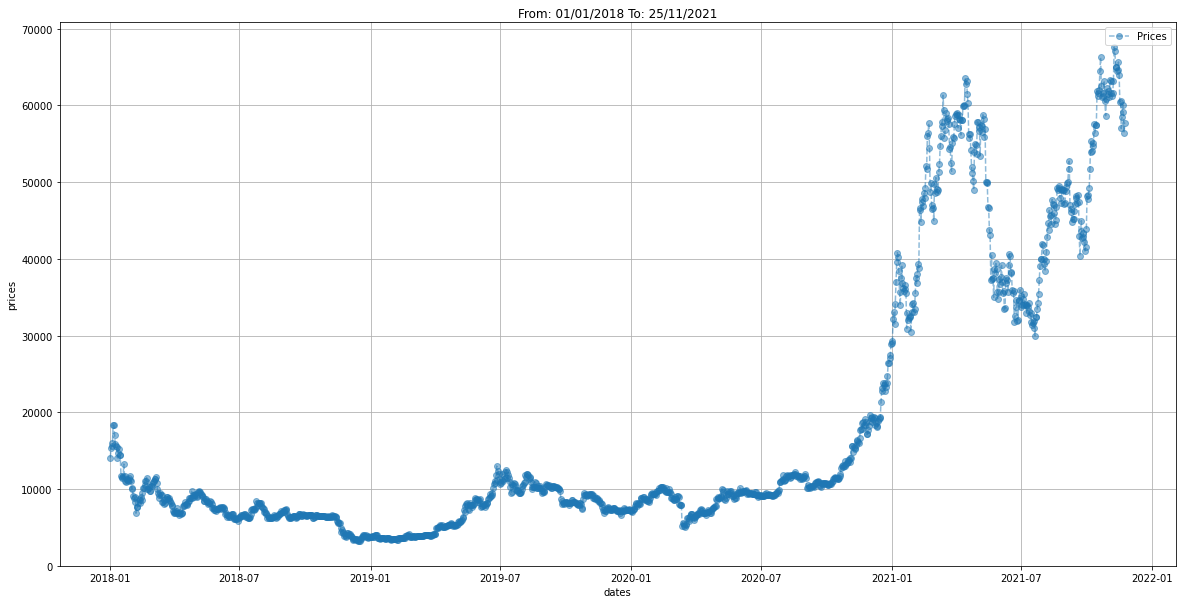

In [135]:
fig=plt.figure(figsize=(20, 10))
plt.plot(df['prices'], '--o', label = 'Prices', alpha = 0.5)
plt.title('From: ' + from_date + ' To: ' + to_date) 
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)

In [136]:
# Esto hay que hacerlo pues es con la info de hoy predecir mañana
df["y"] = df["prices"].shift(-1)
df.tail(5)

,prices,total_volumes,y
dates,,,
2021-11-20,58459.255517,3.785126e+10,60082.911668
2021-11-21,60082.911668,2.967655e+10,59139.779280
2021-11-22,59139.779280,2.574343e+10,56386.856853
2021-11-23,56386.856853,3.400147e+10,57748.793174
2021-11-24,57748.793174,3.642119e+10,NaN


#### Se calculan indicadores para ese día

In [137]:
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
#values_ma = [5,15,30]
#
#for i in values_ma:
#    df["ma_close_" + str(i)] = df["close"].rolling(window=i).mean()
#    df["ma_volume_" + str(i)] = df["volume"].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df["prices"].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,14,21]
close = df['prices']

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df['prices'].rolling(window=i).mean() + (df['prices'].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df['prices'].rolling(window=i).mean() - (df['prices'].rolling(window=i).std()  * 2)

# Rate of change
values_rc = [5,15,30]
for i in values_rc:
    df["rc_" + str(i)] = df["prices"].pct_change(periods = i)
    
# Stochastic Oscillators
#values_so = [5,15,30]
#for i in values_so:
#    lowest = df["low"].rolling(window = i).min()
#    high = df["high"].rolling(window = i).max()
#    df["so_" + str(i)] = ((df['close'] -lowest)/(high - lowest))*100
#    df["so_%D" + str(i)] = df["so_" + str(i)].rolling(window = i).mean()

In [138]:
# Get feature from dates
#df['month'] = df.index.month.astype(str)
#df['day'] = df.index.day
#df['weekday'] = df.index.dayofweek.astype(str)
#df['dayofyear'] = df.index.dayofyear

In [139]:
df.sample()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2020-04-15,6860.178536,3.383737e+10,6629.431738,6911.596846,6873.143144,6919.104764,26.939632,60.964798,51.878689,6920.70795,6829.032582,7475.523336,6583.196232,7505.588349,6043.725858,-0.05954,0.071377,0.27089


In [140]:
df["y"] = 100*( (df["y"] - df["prices"])/df["prices"])   
df.tail(4)

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2021-11-21,60082.911668,2.967655e+10,-1.569718,59945.854855,61663.518176,61215.166452,32.470137,46.480606,46.830976,62428.520747,56204.162415,68164.288708,55888.221212,68312.642859,57212.326578,-0.060233,-0.019013,-0.039305
2021-11-22,59139.779280,2.574343e+10,-4.654942,59677.162996,61348.050814,61081.270505,24.984948,40.826921,45.873479,61899.286405,56209.883463,67431.660020,55447.676724,68404.389504,56922.374741,-0.021651,-0.040894,-0.030960
2021-11-23,56386.856853,3.400147e+10,2.415344,58580.394282,60727.901569,60778.405108,23.139259,22.154860,42.278309,61253.132433,55169.317830,66990.828351,54279.470173,68698.893162,55941.835872,-0.069580,-0.107142,-0.084215
2021-11-24,57748.793174,3.642119e+10,NaN,58303.193913,60355.513019,60582.946274,38.680219,27.686349,40.804333,61165.864340,55561.174256,65840.885540,54047.104549,68732.741026,55369.773090,0.013362,-0.145943,-0.055978


In [141]:
cota_max = 4
cota_min = -4

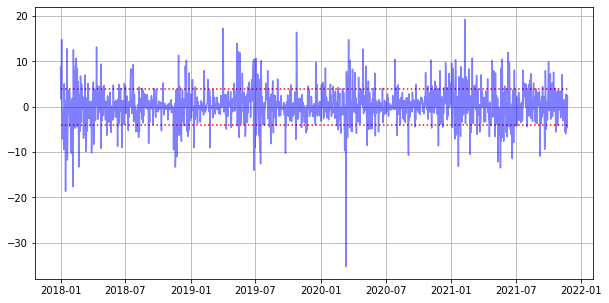

In [142]:
fig=plt.figure(figsize=(10, 5))
plt.plot(df['y'], 'b', label = 'Delta', alpha = 0.5)
plt.hlines(cota_max, df.index.min(), df.index.max(), color='r', ls=':')
plt.hlines(cota_min, df.index.min(), df.index.max(), color='r', ls=':')
plt.grid(True)

In [143]:
# 0: Vender
# 1: Mantener
# 2: Comprar

df['y'] = [0 if x > cota_max else 2 if x < cota_min else 1 for x in df['y']]

In [144]:
df["y"].value_counts()

1    1113
0     165
2     146
Name: y, dtype: int64

In [145]:
print(df.shape)
df.sample()

(1424, 18)


,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2019-06-13,8145.059098,2.218153e+10,1,7989.916875,8017.987357,7775.816038,63.010107,42.29834,55.2115,8279.610379,7582.923009,8269.182728,7567.473953,8973.310873,7447.432161,0.013558,-0.06668,0.043438


In [146]:
all_columns = list(df.columns)
keep_columns = [item for item in all_columns if item not in "y"]
print(keep_columns)

['prices', 'total_volumes', 'ema_5', 'ema_15', 'ema_30', 'rsi_sma_7', 'rsi_sma_14', 'rsi_sma_21', 'bollinger_upper_5', 'bollinger_lower_5', 'bollinger_upper_10', 'bollinger_lower_10', 'bollinger_upper_20', 'bollinger_lower_20', 'rc_5', 'rc_15', 'rc_30']


In [147]:
minus = 15 # Es el lag del pasado cuanto pillamos
list_shift = list(range(1, minus))

for i in list_shift:
    for j in keep_columns:
        df[str(j) + "minus" + str(i)] = df[str(j)].shift(i)

C:\Users\AldoFranco\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [148]:
print("Shape: " + str(df.shape))
df.dropna(inplace = True)
print("Shape: " + str(df.shape))

Shape: (1424, 256)
Shape: (1380, 256)


In [149]:
df.tail(2)

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30,pricesminus1,total_volumesminus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,rc_5minus1,rc_15minus1,rc_30minus1,pricesminus2,total_volumesminus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,rc_5minus2,rc_15minus2,rc_30minus2,pricesminus3,total_volumesminus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,rc_5minus3,rc_15minus3,rc_30minus3,pricesminus4,total_volumesminus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,rc_5minus4,rc_15minus4,rc_30minus4,pricesminus5,total_volumesminus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,rc_5minus5,rc_15minus5,rc_30minus5,pricesminus6,total_volumesminus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,rc_5minus6,rc_15minus6,rc_30minus6,pricesminus7,total_volumesminus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,rc_5minus7,rc_15minus7,rc_30minus7,pricesminus8,total_volumesminus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,rc_5minus8,rc_15minus8,rc_30minus8,pricesminus9,total_volumesminus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,rc_5minus9,rc_15minus9,rc_30minus9,pricesminus10,total_volumesminus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,rc_5minus10,rc_15minus10,rc_30minus10,pricesminus11,total_volumesminus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,rc_5minus11,rc_15minus11,rc_30minus11,pricesminus12,total_volumesminus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_5minus12,bollinger_lower_5minus12,bollinger_upper_10minus12,bollinger_lower_10minus12,bollinger_upper_20minus12,bollinger_lower_20minus12,rc_5minus12,rc_15minus12,rc_30minus12,pricesminus13,total_volumesminus13,ema_5minus13,ema_15minus13,ema_30minus13,rsi_sma_7minus13,rsi

In [150]:
df.dtypes.value_counts()

float64    255
int64        1
dtype: int64

In [152]:
print(df.shape)
cutoff = 1100

train = df[0:cutoff]
print(train.shape)

test = df[cutoff:df.shape[0]]
print(test.shape)
test.tail(1)

(1380, 256)
(1100, 256)
(280, 256)


,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30,pricesminus1,total_volumesminus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,rc_5minus1,rc_15minus1,rc_30minus1,pricesminus2,total_volumesminus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,rc_5minus2,rc_15minus2,rc_30minus2,pricesminus3,total_volumesminus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,rc_5minus3,rc_15minus3,rc_30minus3,pricesminus4,total_volumesminus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,rc_5minus4,rc_15minus4,rc_30minus4,pricesminus5,total_volumesminus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,rc_5minus5,rc_15minus5,rc_30minus5,pricesminus6,total_volumesminus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,rc_5minus6,rc_15minus6,rc_30minus6,pricesminus7,total_volumesminus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,rc_5minus7,rc_15minus7,rc_30minus7,pricesminus8,total_volumesminus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,rc_5minus8,rc_15minus8,rc_30minus8,pricesminus9,total_volumesminus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,rc_5minus9,rc_15minus9,rc_30minus9,pricesminus10,total_volumesminus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,rc_5minus10,rc_15minus10,rc_30minus10,pricesminus11,total_volumesminus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,rc_5minus11,rc_15minus11,rc_30minus11,pricesminus12,total_volumesminus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_5minus12,bollinger_lower_5minus12,bollinger_upper_10minus12,bollinger_lower_10minus12,bollinger_upper_20minus12,bollinger_lower_20minus12,rc_5minus12,rc_15minus12,rc_30minus12,pricesminus13,total_volumesminus13,ema_5minus13,ema_15minus13,ema_30minus13,rsi_sma_7minus13,rsi

In [153]:
X_train = train.drop(columns = ["y"]); print(X_train.shape)
X_test = test.drop(columns = ["y"]); print(X_test.shape)
y_train = train[["y"]]; print(y_train.shape)
y_test = test[["y"]]; print(y_test.shape)

(1100, 255)
(280, 255)
(1100, 1)
(280, 1)


In [156]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=200, activation='sigmoid', input_shape=(X_train.shape[1], )))
model.add(tf.keras.layers.Dense(units=200, activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

LEARNING_RATE = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

In [157]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 200)               51200     
                                                                 
 dense_9 (Dense)             (None, 200)               40200     
                                                                 
 dense_10 (Dense)            (None, 3)                 603       
                                                                 
Total params: 92,003
Trainable params: 92,003
Non-trainable params: 0
_________________________________________________________________


In [167]:
from tqdm import tqdm_notebook as tqdm
from tqdm.keras import TqdmCallback

NUM_EPOCHS=250
BATCH_SIZE = 16
history = model.fit(X_train, y_train,
                    epochs = NUM_EPOCHS,
                    batch_size  = BATCH_SIZE,
                    validation_split = 0.15,
                    callbacks = [TqdmCallback(verbose=2)],
                    verbose = 0)

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

  0%|          | 0.00/59.0 [00:00<?, ?batch/s]

In [168]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 3.1891 - sparse_categorical_accuracy: 0.5536


In [169]:
def plotCurves(history,epochs):

    plt.plot(history.history['sparse_categorical_accuracy'],'r')
    plt.plot(history.history['val_sparse_categorical_accuracy'],'g')
    plt.xticks(np.arange(0, epochs, 50.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("categorical_accuracy")
    plt.title("Training vs Validation Sparse Categorical Accuracy")
    plt.legend(['train','validation'])
 
    plt.show()

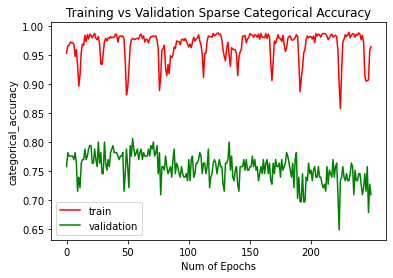

In [170]:
plotCurves(history,NUM_EPOCHS)

In [171]:
predictions = model.predict(X_test)

In [172]:
from sklearn.metrics import confusion_matrix
labels = [0,1,2]
cm=confusion_matrix(y_test.values,
                    predictions.argmax(axis=1))
cm

array([[  4,  29,   4],
       [ 32, 149,  28],
       [  2,  30,   2]], dtype=int64)

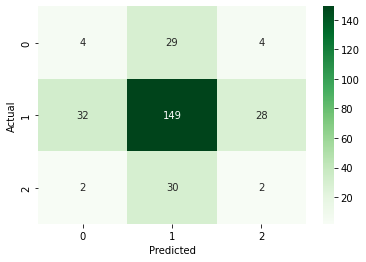

In [173]:
import seaborn as sns
%matplotlib inline

sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Greens')
plt.ylabel('Actual')
plt.xlabel('Predicted');

In [174]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
print(accuracy_score(y_test.values,
                    predictions.argmax(axis=1)))
print(classification_report(y_test.values,
                    predictions.argmax(axis=1)))

0.5535714285714286
              precision    recall  f1-score   support

           0       0.11      0.11      0.11        37
           1       0.72      0.71      0.71       209
           2       0.06      0.06      0.06        34

    accuracy                           0.55       280
   macro avg       0.29      0.29      0.29       280
weighted avg       0.56      0.55      0.55       280



### Telegram

In [167]:
import telepot

bot_token = '1653124784:AAFpL0qlC_ybadcbFX6jKagauRFpiFpSf1E'
chatID = '-625272860'

bot = telepot.Bot(bot_token)

In [168]:
#ot.sendMessage(bot_chatID, "HALA")
bot.sendPhoto(chatID, photo=open('imagen.png', 'rb'))

{'message_id': 107,
 'from': {'id': 1653124784,
  'is_bot': True,
  'first_name': 'JARVIS',
  'username': 'JARVIS_Walkn_bot'},
 'chat': {'id': -625272860,
  'title': 'Trading',
  'type': 'group',
  'all_members_are_administrators': True},
 'date': 1637896017,
 'photo': [{'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADcwADIgQ',
   'file_unique_id': 'AQAD6LcxGxRjAAFReA',
   'file_size': 758,
   'width': 90,
   'height': 45},
  {'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADbQADIgQ',
   'file_unique_id': 'AQAD6LcxGxRjAAFRcg',
   'file_size': 9967,
   'width': 320,
   'height': 160},
  {'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADeAADIgQ',
   'file_unique_id': 'AQAD6LcxGxRjAAFRfQ',
   'file_size': 41074,
   'width': 800,
   'height': 400},
  {'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADeQADIgQ',
   'file_unique_id': 'AQAD